# Credit Card Fraud Detection
### Recognize fraudulent credit card transactions
### 4.2 Semi-supervised learning(AE)
             KwangMyung Yu, Senior Researcher, Korea Electric Power Corporation

- 참고자료 : https://www.kaggle.com/shivamb/semi-supervised-classification-using-autoencoders

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 30 #중요

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import recall_score,precision_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from tensorflow.keras.utils import plot_model

In [71]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [19]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [20]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize = 16)
    plt.yticks(tick_marks, classes, fontsize = 16)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", 
                 fontsize = 18)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
data = pd.concat([X_train, y_train], axis = 1  )

In [52]:
X_train_normal = X_train.iloc[y_train[y_train['Class']==0].index.tolist(), :]

In [53]:
X_train_fraud = X_train.iloc[y_train[y_train['Class']==1].index.tolist(), :]

In [63]:
X_test_normal = X_test.iloc[y_test[y_test['Class']==0].index.tolist(), :]
X_test_fraud = X_test.iloc[y_test[y_test['Class']==1].index.tolist(), :]

#### 원본 데이터 시각화

In [29]:
def tsne_plot(x1, y1):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.show();

2000개의 정상거래와 비정상 거래만 살펴보자

In [30]:
non_fraud = data[data['Class']==0].sample(2000)
fraud = data[data['Class']==1]

In [31]:
data_sample = pd.concat([non_fraud, fraud], axis = 0).sample(frac = 1).\
                reset_index(drop = True)
# frac : 전체의 몇%를 샘플링할 것인지 설정
# frac=1로 설정하면 셔플링하는 효과

In [32]:
data_sample.shape

(2344, 30)

In [33]:
X_sample = data_sample.drop(['Class'], axis = 1).values
y_sample = data_sample['Class'].values

In [1]:
#tsne_plot(X_sample, y_sample)

#### Autoencoder

In [35]:
X_train_normal.shape

(199020, 29)

모델 만들기

In [36]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

In [37]:
input = Input(shape = (X_train_normal.shape[1],))
## encoding part
encod1 = Dense(100, activation='tanh', 
                activity_regularizer=regularizers.l1(10e-5))(input)
encod2 = Dense(50, activation='relu')(encod1)

In [ ]:
decod1 = Dense(50, activation='tanh')(encod2)
decod2 = Dense(100, activation='tanh')(decod1)

output = Dense(units = X_train_normal.shape[1], activation='relu')(decod2)

In [39]:
autoencoder = Model(input, output)
autoencoder.compile(optimizer = 'adadelta', loss = 'mse')

In [40]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               3000      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 29)                2929      
Total params: 18,629
Trainable params: 18,629
Non-trainable params: 0
_________________________________________________________

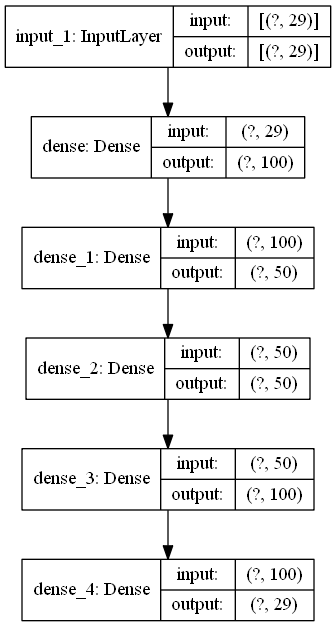

In [42]:
plot_model(autoencoder, show_shapes=True)

모델 학습하기

In [45]:
autoencoder.fit(X_train_normal, X_train_normal, 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Train on 159216 samples, validate on 39804 samples
Epoch 1/10
159216/159216 [==============================] - 1s 9us/sample - loss: 0.1986 - val_loss: 0.1726
Epoch 2/10
159216/159216 [==============================] - 1s 9us/sample - loss: 0.1533 - val_loss: 0.1377
Epoch 3/10
159216/159216 [==============================] - 1s 9us/sample - loss: 0.1283 - val_loss: 0.1204
Epoch 4/10
159216/159216 [==============================] - 1s 9us/sample - loss: 0.1165 - val_loss: 0.1133
Epoch 5/10
159216/159216 [==============================] - 1s 9us/sample - loss: 0.1119 - val_loss: 0.1111
Epoch 6/10
159216/159216 [==============================] - 1s 9us/sample - loss: 0.1109 - val_loss: 0.1108
Epoch 7/10
159216/159216 [==============================] - 1s 9us/sample - loss: 0.1108 - val_loss: 0.1108
Epoch 8/10
159216/159216 [==============================] - 1s 9us/sample - loss: 0.1108 - val_loss: 0.1108
Epoch 9/10
159216/159216 [==============================] - 1s 9us/sample - loss: 0.1

Encoder 만들기

In [46]:
autoencoder.layers

In [48]:
len(autoencoder.layers)

6

In [49]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               3000      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 29)                2929      
Total params: 18,629
Trainable params: 18,629
Non-trainable params: 0
_________________________________________________________

In [51]:
encoder = Sequential()
encoder.add(autoencoder.layers[0])
encoder.add(autoencoder.layers[1])
encoder.add(autoencoder.layers[2])

#### 잠재공간 데이터 시각화

In [56]:
norm_hid_rep = encoder.predict(X_train_normal[:2000])
fraud_hid_rep = encoder.predict(X_train_fraud)

In [57]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

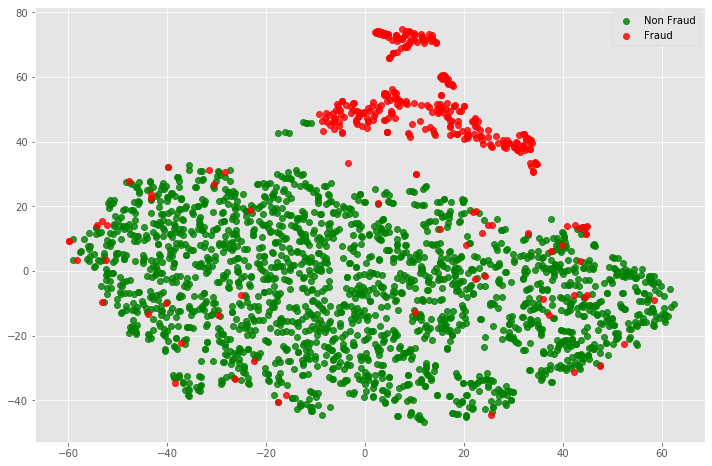

In [58]:
tsne_plot(rep_x, rep_y)

#### 분류기

In [59]:
norm_hid_rep = encoder.predict(X_train_normal)
fraud_hid_rep = encoder.predict(X_train_fraud)
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [64]:
norm_hid_rep = encoder.predict(X_test_normal)
fraud_hid_rep = encoder.predict(X_test_fraud)
X_test = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_test_n = np.zeros(norm_hid_rep.shape[0])
y_test_f = np.ones(fraud_hid_rep.shape[0])
y_test = np.append(y_test_n, y_test_f)

#### Xgboost

In [61]:
XGB = XGBClassifier()
XGB.fit(rep_x, rep_y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

Test Result(Base_XGB)
accuracy :  0.999403110845827
precsion : 0.9292035398230089
recall :  0.7094594594594594


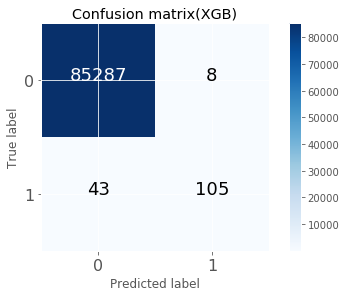

In [65]:
y_pred = XGB.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Test Result(Base_XGB)')
print('accuracy : ', acc)
print('precsion :', precision)
print('recall : ', recall)

class_names = [0,1]
plot_confusion_matrix(conf_mat , classes=class_names,
                      title='Confusion matrix(XGB)')
plt.show()

#### LGBM

In [66]:
LGBM = LGBMClassifier()
LGBM.fit(rep_x, rep_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Test Result(Base_LGBM)
accuracy :  0.9797759910115516
precsion : 0.017704517704517704
recall :  0.19594594594594594


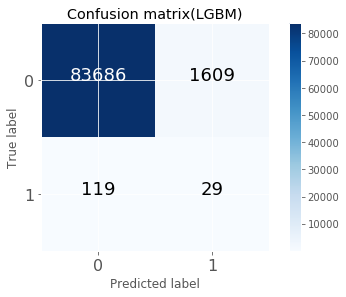

In [68]:
y_pred = LGBM.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Test Result(Base_LGBM)')
print('accuracy : ', acc)
print('precsion :', precision)
print('recall : ', recall)

class_names = [0,1]
plot_confusion_matrix(conf_mat , classes=class_names,
                      title='Confusion matrix(LGBM)')
plt.show()

#### CatBoost

In [69]:
Cat = CatBoostClassifier()
Cat.fit(rep_x, rep_y)

Learning rate set to 0.098829
0:	learn: 0.4091887	total: 87.4ms	remaining: 1m 27s
1:	learn: 0.2321793	total: 110ms	remaining: 55.1s
2:	learn: 0.1367189	total: 128ms	remaining: 42.4s
3:	learn: 0.0824733	total: 145ms	remaining: 36.2s
4:	learn: 0.0497534	total: 165ms	remaining: 32.9s
5:	learn: 0.0321934	total: 186ms	remaining: 30.9s
6:	learn: 0.0219541	total: 208ms	remaining: 29.6s
7:	learn: 0.0158074	total: 227ms	remaining: 28.2s
8:	learn: 0.0119932	total: 250ms	remaining: 27.5s
9:	learn: 0.0095812	total: 270ms	remaining: 26.7s
10:	learn: 0.0080652	total: 291ms	remaining: 26.1s
11:	learn: 0.0069100	total: 309ms	remaining: 25.5s
12:	learn: 0.0062173	total: 329ms	remaining: 25s
13:	learn: 0.0055968	total: 348ms	remaining: 24.5s
14:	learn: 0.0051015	total: 366ms	remaining: 24.1s
15:	learn: 0.0047746	total: 385ms	remaining: 23.7s
16:	learn: 0.0045265	total: 403ms	remaining: 23.3s
17:	learn: 0.0043351	total: 422ms	remaining: 23s
18:	learn: 0.0041615	total: 440ms	remaining: 22.7s
19:	learn: 0.

163:	learn: 0.0018864	total: 3.34s	remaining: 17s
164:	learn: 0.0018837	total: 3.37s	remaining: 17s
165:	learn: 0.0018792	total: 3.38s	remaining: 17s
166:	learn: 0.0018747	total: 3.4s	remaining: 17s
167:	learn: 0.0018741	total: 3.42s	remaining: 17s
168:	learn: 0.0018717	total: 3.44s	remaining: 16.9s
169:	learn: 0.0018597	total: 3.46s	remaining: 16.9s
170:	learn: 0.0018571	total: 3.48s	remaining: 16.9s
171:	learn: 0.0018563	total: 3.49s	remaining: 16.8s
172:	learn: 0.0018559	total: 3.51s	remaining: 16.8s
173:	learn: 0.0018511	total: 3.54s	remaining: 16.8s
174:	learn: 0.0018471	total: 3.56s	remaining: 16.8s
175:	learn: 0.0018403	total: 3.58s	remaining: 16.7s
176:	learn: 0.0018367	total: 3.59s	remaining: 16.7s
177:	learn: 0.0018362	total: 3.61s	remaining: 16.7s
178:	learn: 0.0018329	total: 3.63s	remaining: 16.7s
179:	learn: 0.0018297	total: 3.65s	remaining: 16.6s
180:	learn: 0.0018234	total: 3.67s	remaining: 16.6s
181:	learn: 0.0018207	total: 3.69s	remaining: 16.6s
182:	learn: 0.0018202	t

325:	learn: 0.0013305	total: 6.54s	remaining: 13.5s
326:	learn: 0.0013280	total: 6.57s	remaining: 13.5s
327:	learn: 0.0013250	total: 6.58s	remaining: 13.5s
328:	learn: 0.0013196	total: 6.6s	remaining: 13.5s
329:	learn: 0.0013189	total: 6.62s	remaining: 13.4s
330:	learn: 0.0013163	total: 6.64s	remaining: 13.4s
331:	learn: 0.0013109	total: 6.65s	remaining: 13.4s
332:	learn: 0.0013099	total: 6.67s	remaining: 13.4s
333:	learn: 0.0013079	total: 6.69s	remaining: 13.3s
334:	learn: 0.0013059	total: 6.71s	remaining: 13.3s
335:	learn: 0.0013042	total: 6.73s	remaining: 13.3s
336:	learn: 0.0012996	total: 6.75s	remaining: 13.3s
337:	learn: 0.0012995	total: 6.77s	remaining: 13.3s
338:	learn: 0.0012977	total: 6.78s	remaining: 13.2s
339:	learn: 0.0012971	total: 6.8s	remaining: 13.2s
340:	learn: 0.0012928	total: 6.82s	remaining: 13.2s
341:	learn: 0.0012868	total: 6.84s	remaining: 13.2s
342:	learn: 0.0012867	total: 6.86s	remaining: 13.1s
343:	learn: 0.0012842	total: 6.87s	remaining: 13.1s
344:	learn: 0.

484:	learn: 0.0009485	total: 9.76s	remaining: 10.4s
485:	learn: 0.0009447	total: 9.78s	remaining: 10.3s
486:	learn: 0.0009386	total: 9.8s	remaining: 10.3s
487:	learn: 0.0009359	total: 9.82s	remaining: 10.3s
488:	learn: 0.0009349	total: 9.84s	remaining: 10.3s
489:	learn: 0.0009331	total: 9.86s	remaining: 10.3s
490:	learn: 0.0009308	total: 9.87s	remaining: 10.2s
491:	learn: 0.0009280	total: 9.89s	remaining: 10.2s
492:	learn: 0.0009261	total: 9.91s	remaining: 10.2s
493:	learn: 0.0009246	total: 9.93s	remaining: 10.2s
494:	learn: 0.0009245	total: 9.95s	remaining: 10.2s
495:	learn: 0.0009227	total: 9.97s	remaining: 10.1s
496:	learn: 0.0009209	total: 9.99s	remaining: 10.1s
497:	learn: 0.0009208	total: 10s	remaining: 10.1s
498:	learn: 0.0009195	total: 10s	remaining: 10.1s
499:	learn: 0.0009194	total: 10s	remaining: 10s
500:	learn: 0.0009186	total: 10.1s	remaining: 10s
501:	learn: 0.0009162	total: 10.1s	remaining: 10s
502:	learn: 0.0009146	total: 10.1s	remaining: 9.98s
503:	learn: 0.0009142	tot

647:	learn: 0.0006768	total: 13.1s	remaining: 7.14s
648:	learn: 0.0006734	total: 13.2s	remaining: 7.12s
649:	learn: 0.0006720	total: 13.2s	remaining: 7.1s
650:	learn: 0.0006701	total: 13.2s	remaining: 7.08s
651:	learn: 0.0006684	total: 13.2s	remaining: 7.06s
652:	learn: 0.0006678	total: 13.2s	remaining: 7.04s
653:	learn: 0.0006664	total: 13.3s	remaining: 7.02s
654:	learn: 0.0006660	total: 13.3s	remaining: 7s
655:	learn: 0.0006636	total: 13.3s	remaining: 6.98s
656:	learn: 0.0006622	total: 13.3s	remaining: 6.96s
657:	learn: 0.0006609	total: 13.3s	remaining: 6.93s
658:	learn: 0.0006589	total: 13.4s	remaining: 6.92s
659:	learn: 0.0006582	total: 13.4s	remaining: 6.89s
660:	learn: 0.0006576	total: 13.4s	remaining: 6.87s
661:	learn: 0.0006563	total: 13.4s	remaining: 6.85s
662:	learn: 0.0006541	total: 13.4s	remaining: 6.83s
663:	learn: 0.0006541	total: 13.5s	remaining: 6.81s
664:	learn: 0.0006529	total: 13.5s	remaining: 6.79s
665:	learn: 0.0006524	total: 13.5s	remaining: 6.77s
666:	learn: 0.00

813:	learn: 0.0004882	total: 16.5s	remaining: 3.77s
814:	learn: 0.0004874	total: 16.5s	remaining: 3.75s
815:	learn: 0.0004874	total: 16.5s	remaining: 3.73s
816:	learn: 0.0004862	total: 16.6s	remaining: 3.71s
817:	learn: 0.0004853	total: 16.6s	remaining: 3.69s
818:	learn: 0.0004841	total: 16.6s	remaining: 3.67s
819:	learn: 0.0004827	total: 16.6s	remaining: 3.65s
820:	learn: 0.0004807	total: 16.6s	remaining: 3.63s
821:	learn: 0.0004805	total: 16.7s	remaining: 3.61s
822:	learn: 0.0004794	total: 16.7s	remaining: 3.59s
823:	learn: 0.0004793	total: 16.7s	remaining: 3.57s
824:	learn: 0.0004751	total: 16.7s	remaining: 3.55s
825:	learn: 0.0004734	total: 16.8s	remaining: 3.53s
826:	learn: 0.0004734	total: 16.8s	remaining: 3.51s
827:	learn: 0.0004734	total: 16.8s	remaining: 3.49s
828:	learn: 0.0004733	total: 16.8s	remaining: 3.47s
829:	learn: 0.0004733	total: 16.8s	remaining: 3.45s
830:	learn: 0.0004733	total: 16.8s	remaining: 3.42s
831:	learn: 0.0004708	total: 16.9s	remaining: 3.4s
832:	learn: 0

981:	learn: 0.0003612	total: 19.9s	remaining: 364ms
982:	learn: 0.0003607	total: 19.9s	remaining: 344ms
983:	learn: 0.0003607	total: 19.9s	remaining: 324ms
984:	learn: 0.0003606	total: 19.9s	remaining: 304ms
985:	learn: 0.0003600	total: 20s	remaining: 283ms
986:	learn: 0.0003588	total: 20s	remaining: 263ms
987:	learn: 0.0003583	total: 20s	remaining: 243ms
988:	learn: 0.0003576	total: 20s	remaining: 223ms
989:	learn: 0.0003571	total: 20s	remaining: 202ms
990:	learn: 0.0003567	total: 20.1s	remaining: 182ms
991:	learn: 0.0003557	total: 20.1s	remaining: 162ms
992:	learn: 0.0003551	total: 20.1s	remaining: 142ms
993:	learn: 0.0003550	total: 20.1s	remaining: 121ms
994:	learn: 0.0003531	total: 20.1s	remaining: 101ms
995:	learn: 0.0003523	total: 20.2s	remaining: 80.9ms
996:	learn: 0.0003516	total: 20.2s	remaining: 60.7ms
997:	learn: 0.0003515	total: 20.2s	remaining: 40.5ms
998:	learn: 0.0003499	total: 20.2s	remaining: 20.2ms
999:	learn: 0.0003499	total: 20.2s	remaining: 0us


Test Result(Base_Cat)
accuracy :  0.9994616293903538
precsion : 0.9322033898305084
recall :  0.7432432432432432


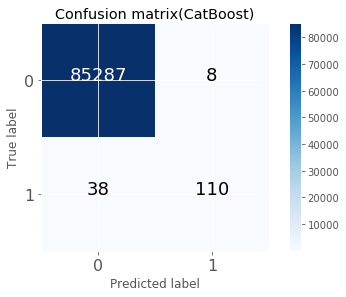

In [70]:
y_pred = Cat.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Test Result(Base_Cat)')
print('accuracy : ', acc)
print('precsion :', precision)
print('recall : ', recall)

class_names = [0,1]
plot_confusion_matrix(conf_mat , classes=class_names,
                      title='Confusion matrix(CatBoost)')
plt.show()

#### Logistic Regression

In [72]:
LR = LogisticRegression(solver='lbfgs')
LR.fit(rep_x, rep_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Test Result(Base_LR)
accuracy :  0.9985604438046417
precsion : 0.7906976744186046
recall :  0.22972972972972974


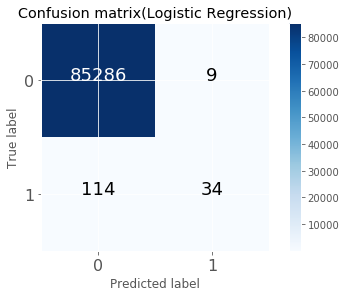

In [73]:
y_pred = LR.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Test Result(Base_LR)')
print('accuracy : ', acc)
print('precsion :', precision)
print('recall : ', recall)

class_names = [0,1]
plot_confusion_matrix(conf_mat , classes=class_names,
                      title='Confusion matrix(Logistic Regression)')
plt.show()

### SVM

In [74]:
svm = SVC()
svm.fit(rep_x, rep_y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Test Result(Base_SVM)
accuracy :  0.9989232587807076
precsion : 0.8589743589743589
recall :  0.4527027027027027


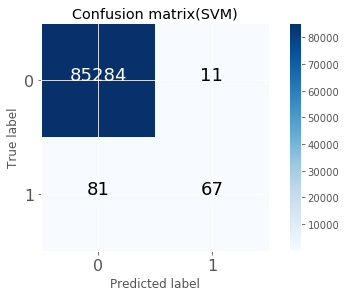

In [75]:
y_pred = svm.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Test Result(Base_SVM)')
print('accuracy : ', acc)
print('precsion :', precision)
print('recall : ', recall)

class_names = [0,1]
plot_confusion_matrix(conf_mat , classes=class_names,
                      title='Confusion matrix(SVM)')
plt.show()